<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/7_Modelos_Generativos/ejercicios/ejercicios_solucion.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Ejercicios Clase 7

Hasta ahora, todas las aplicaciones de las redes neuronales que hemos explorado han sido **modelos discriminativos** que toman una entrada y están entrenados para producir una salida etiquetada. En este notebook, vamos a ampliar nuestro repertorio al crear **modelos generativos** utilizando redes neuronales. Específicamente, camos a aprender a construir modelos que generen imágenes novedosas que se asemejen a un conjunto de imágenes de entrenamiento.

### ¿Qué es una GAN?

En 2014, [Goodfellow et al.] (Https://arxiv.org/abs/1406.2661) presentó un método para entrenar modelos generativos llamado Redes Adversarias Generativas (GAN, por sus siglas en inglés). En una GAN, construimos dos redes neuronales diferentes. Nuestra primera red es una red de clasificación tradicional, llamada **discriminador**. Vamos a entrenar al discriminador para tomar imágenes y clasificarlas como reales (pertenecientes al conjunto de entrenamiento) o falsas (no presentes en el conjunto de entrenamiento). Nuestra otra red, llamada **generador**, va a tomar ruido aleatorio como entrada y lo va a transformar usando una red neuronal para producir imágenes. El objetivo del generador es engañar al discriminador haciéndole creer que las imágenes que produjo son reales.

Podemos pensar en este proceso de ida y vuelta del generador ($ G $) tratando de engañar al discriminador ($ D $), y el discriminador tratando de clasificar correctamente lo real frente a lo falso como un juego minimax:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
donde $ z \sim p (z) $ son las muestras de ruido aleatorias, $ G (z) $ son las imágenes generadas usando el generador $ G $ y $ D() $ es la salida del discriminador, especificando la probabilidad de que una entrada sea real.  En [Goodfellow et al.] (Https://arxiv.org/abs/1406.2661), analizan este juego minimax y muestran cómo se relaciona con minimizar la divergencia Jensen-Shannon entre la distribución de datos de entrenamiento y las muestras generadas a partir de $ G $

Para optimizar este juego minimax, alternaremos entre tomar pasos de gradiente * descendiente * en la función de pérdida de $ G $ y pasos de gradiente * ascendiente * en la función de pérdida de $ D $:
1. Actualizar el **generador** ($ G $) para minimizar la probabilidad de que el __discriminador tome la decisión correcta__.
2. Actualizar el **discriminador** ($ D $) para maximizar la probabilidad de que el __discriminador tome la decisión correcta__.

Si bien estas actualizaciones son útiles para el análisis, no funcionan bien en la práctica. En cambio, usaremos un objetivo diferente cuando actualicemos el generador: maximizar la probabilidad de que el ** discriminador haga la elección incorrecta **. Este pequeño cambio ayuda a aliviar los problemas con la desaparición del gradiente del generador cuando el discriminador tiene confianza. Esta es la actualización estándar utilizada en la mayoría de los artículos de GAN y se utilizó en el artículo original de [Goodfellow et al.] (Https://arxiv.org/abs/1406.2661).


En este práctico, alternaremos entre las siguientes actualizaciones:
1. Actualizar el generador ($ G $) para maximizar la probabilidad de que el discriminador haga la elección incorrecta en los datos generados:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Actualizar el discriminador ($ D $), para maximizar la probabilidad de que el discriminador haga la elección correcta en datos reales y generados:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### ¿Qué más hay para ver?
Desde 2014, las GAN se han convertido en un área de investigación enorme, con [talleres educacionales] masivos (https://sites.google.com/site/nips2016adversarial/) y [cientos de artículos nuevos] (https://github.com/ hindupuravinash / the-gan-zoo). En comparación con otros enfoques para modelos generativos, a menudo producen muestras de la más alta calidad, pero son algunos de los modelos más difíciles y meticulosos de entrenar (consulte [este repositorio de github] (https://github.com/soumith/ganhacks) que contiene un conjunto de 17 trucos útiles para que los modelos funcionen). Mejorar la estabilidad y solidez de la formación GAN es una cuestión de investigación abierta, ¡con nuevos artículos que salen todos los días! Para obtener un tutorial más reciente sobre GAN, consulte [aquí] (https://arxiv.org/abs/1701.00160). También hay un trabajo emocionante aún más reciente que cambia la función objetivo a la distancia de Wasserstein y produce resultados mucho más estables en las arquitecturas de modelos: [WGAN] (https://arxiv.org/abs/1701.07875), [WGAN-GP] ( https://arxiv.org/abs/1704.00028).


¡Las GAN no son la única forma de entrenar un modelo generativo! Para conocer otros enfoques del modelado generativo, consulte el [capítulo sobre el modelo generativo profundo] (http://www.deeplearningbook.org/contents/generative_models.html) del [libro] de aprendizaje profundo (http://www.deeplearningbook.org) . Otra forma popular de entrenar redes neuronales como modelos generativos son los autocodificadores automáticos variacionales (VAE por sus siglas en inglés) (co-descubierto [aquí] (https://arxiv.org/abs/1312.6114) y [aquí] (https://arxiv.org/abs/1401.4082) ). Los autocodificadores variacionales combinan redes neuronales con inferencia variacional para entrenar modelos generativos profundos. Estos modelos tienden a ser mucho más estables y fáciles de entrenar, pero actualmente no producen muestras tan bonitas como las GAN.

Aquí hay un ejemplo de cómo deberían verse sus resultados de los 3 modelos diferentes que va a entrenar ... tenga en cuenta que las GAN a veces son meticulosas, por lo que es posible que sus resultados no se vean exactamente así ... esto solo está destinado a ser un *guía aproximada* del tipo de calidad que puede esperar:

![An image](https://i.imgur.com/y56vi1g.png)

## Setup

En esta sección vamos a importar todos los módulos necesarios y a definir algunas funciones que nos van a ser útiles.

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [3]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Cuenta la cantidad de parámteros presentes en el grafo computacional """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


In [5]:
!gdown https://drive.google.com/uc?id=1WMVK8XB1FZiMNA0Y4U1X2gBonmJOAdk_
answers = dict(np.load('gan-checks-tf.npz'))

Downloading...
From: https://drive.google.com/uc?id=1WMVK8XB1FZiMNA0Y4U1X2gBonmJOAdk_
To: /content/gan-checks-tf.npz
100% 2.19k/2.19k [00:00<00:00, 13.6MB/s]


## Dataset
Las GAN son notoriamente meticulosas con los hiperparámetros y también requieren muchas épocas de entrenamiento. Para que esta tarea sea accesible para un trabajo práctico, trabajaremos en el conjunto de datos MNIST, que consta de 60.000 imágenes de entrenamiento y 10.000 imágenes de prueba. Cada imagen contiene una imagen centrada de dígitos blancos sobre fondo negro (0 a 9). Este fue uno de los primeros conjuntos de datos utilizados para entrenar redes neuronales convolucionales y es bastante fácil de resolver: un modelo CNN estándar puede superar fácilmente el 99% de precisión.

Para simplificar nuestro código aquí, usaremos el contenedor PyTorch MNIST, que descarga y carga el conjunto de datos MNIST. Consulte la [documentación] (https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) para obtener más información sobre la interfaz. Los parámetros predeterminados tomarán 5,000 de los ejemplos de entrenamiento y los colocarán en un conjunto de datos de validación. Los datos se guardarán en una carpeta llamada `MNIST_data`.

In [ ]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = next(iter(loader_train))[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Ruido aleatorio
Implemente `sample_noise` para que genere un ruido uniforme de -1 a 1 con la forma "[batch_size, dim]".

Sugerencia: use `torch.rand`.

Asegurate de que el ruido tenga la forma y el tipo correctos.

In [ ]:
NOISE_DIM = 96

def sample_noise(batch_size, dim, seed=None):
    """
    Genera un tensor de PyTorch con ruido aleatorio uniforme.

    Entradas:
    - batch_size: número entero que indica el tamaño del lote de ruido a generar.
    - dim: número entero que da la dimensión del ruido a generar.

    Salidas:
    - Un tensor de PyTorch con forma (batch_size, dim) que contiene ruido aleatorio
    uniforme en el rango (-1, 1).
    """
    if seed is not None:
        torch.manual_seed(seed)

    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    return torch.Tensor(batch_size, dim).uniform_(-1, 1)

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

In [ ]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('Su código superó todos los tests realizados!')

test_sample_noise()

Su código superó todos los tests realizados!


## Flatten

Proporcionamos una función Flatten y Unflatten, que pueden ser utilizadas al implementar el generador convolucional. También proporcionamos un inicializador de pesos que usa la inicialización de Xavier en lugar del uniforme predeterminado de PyTorch.

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() #
        return x.view(N, -1)  # "aplasta" los valores de C * H * W en un solo vector por imagen

class Unflatten(nn.Module):
    """
    Recibe una entrada de forma (N, C * H * W) y la reforma para producir una
    salida de forma (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)


## CPU / GPU
De forma predeterminada, todo el código se ejecutará en la CPU. No se necesitan GPU para esta tarea, pero te ayudarán a entrenar tus modelos más rápido. Si querés ejecutar el código en una GPU, cambiá la variable `dtype` en la siguiente celda.
** Si estás en Colab, se recomienda cambiar el tiempo de ejecución de colab a GPU. **

In [ ]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminador
Nuestro primer paso es construir un discriminador. Complete la arquitectura como parte del constructor `nn.Sequential` en la función siguiente. Todas las capas densas deben incluir términos de bias. La arquitectura es:
  * Capa densa con tamaño de entrada 784 y tamaño de salida 256
  * LeakyReLU con alfa 0.01
  * Capa densa con input_size 256 y output size 256
  * LeakyReLU con alfa 0.01
  * Capa densa con tamaño de entrada 256 y tamaño de salida 1

Recuerde que la no linealidad de ReLU con fugas calcula $ f (x) = \max (\alpha x, x) $ para alguna constante fija $ \alpha $; para las no linealidades de LeakyReLU en la arquitectura anterior, establecemos $ \alpha = 0.01 $.

La salida del discriminador debe tener la forma `[batch_size, 1]`, y contener números reales correspondientes a las puntuaciones de que cada una de las entradas de `batch_size` es una imagen real.

Implementar `discriminator` en la celda siguiente.

In [ ]:
def discriminator(seed=None):
    """
    Crea y devuelve un modelo de PyTorch que implemente la arquitectura anterior.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    ##############################################################################
    # TODO: Implementá la arquitectura                                           #
    #                                                                            #
    # TIP: nn.Sequential puede ser útil.                                         #
    ##############################################################################
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    model = nn.Sequential(Flatten(),
                          nn.Linear(784, 256), nn.LeakyReLU(0.01),
                          nn.Linear(256, 256), nn.LeakyReLU(0.01),
                          nn.Linear(256, 1)
                          )

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    ##############################################################################
    #                               FIN DE SU CÓDIGO                            #
    ##############################################################################
    return model

Asegurate con el siguiente código de que el número de parámetros en el discriminador sea correcto:

In [ ]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Número incorrecto de parámetros en el discriminador. Revisá tu arquitectura.')
    else:
        print('Número correcto de parámetros en el discriminador.')

test_discriminator()

Número correcto de parámetros en el discriminador.


# Generador
Ahora para construir el generador con la siguiente arquitectura:

  * Capa densa desde noise_dim hasta 1024
  * `ReLU`
  * Capa densa con tamaño 1024
  * `ReLU`
  * Capa densa con tamaño 784
  * `TanH` (para formatear los valores de los píxeles de la imagen para que esté en el rango de [-1,1])

  Implementar `generator` en la siguiente celda

Asegurate con el siguiente código de que el número de parámetros en el generador sea correcto:

In [ ]:
def generator(noise_dim=NOISE_DIM, seed=None):
    """
    Crea y devuelve un modelo de PyTorch que implemente la arquitectura anterior.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    ##############################################################################
    # TODO: Implementá la arquitectura                                           #
    #                                                                            #
    # TIP: nn.Sequential puede ser útil.                                         #
    ##############################################################################
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    model = nn.Sequential(nn.Linear(noise_dim, 1024), nn.ReLU(),
                          nn.Linear(1024, 1024), nn.ReLU(),
                          nn.Linear(1024, 784), nn.Tanh()
                          )

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    ##############################################################################
    #                               FIN DE SU CÓDIGO                            #
    ##############################################################################
    return model

In [ ]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Número incorrecto de parámetros en el generador. Revisá tu arquitectura.')
    else:
        print('Número correcto de parámetros en el generador.')

test_generator()

Número correcto de parámetros en el generador.


# GAN Loss

Calcule la pérdida del generador y el discriminador. La pérdida del generador es:
$$ \ell_G = - \mathbb {E} _ {z \sim p(z)} \left [\log D (G (z)) \right] $$
y la pérdida del discriminador es:
$$ \ell_D = - \mathbb{E} _ {x \sim p_ \text {data}} \left [\log D (x) \right] - \mathbb {E} _ {z \sim p (z) } \left [\log \left (1-D (G (z)) \right) \right] $$

Tenga en cuenta que estas son las ecuaciones presentadas anteriormente pero negadas, ya que estaremos *minimizando* estas pérdidas.

**SUGERENCIA**: Debería usar la función `bce_loss` definida a continuación para calcular la pérdida de entropía cruzada binaria que se necesita para calcular la probabilidad logarítmica de la etiqueta verdadera dada la salida de logits del discriminador. Dada una puntuación $ s \in \mathbb {R} $ y una etiqueta $y \in \{0, 1 \}$ , la pérdida de entropía cruzada binaria es

$$ bce (s, y) = -y * \log (s) - (1 - y) * \log (1 - s) $$

Una implementación ingenua de esta fórmula puede ser numéricamente inestable, por lo que a continuación le proporcionamos una implementación numéricamente estable.

También necesitará calcular las etiquetas para las imágenes correspondientes a "reales" o "falsas" y usar los argumentos logit para determinar su tamaño. Asegurate de convertir estas etiquetas al tipo de datos correcto usando la variable global `dtype`, por ejemplo:


`true_labels = torch.ones(size).type(dtype)`

En lugar de calcular la esperanza de $ \log D (G (z)) $, $ \log D (x) $ y $ \log \left (1-D (G (z)) \right) $, vamos a promediar los elementos del minibatch, así que asegurate de combinar la pérdida promediando en lugar de sumando.

Implementar `bce_loss`,` discriminator_loss`, `generator_loss` en las siguientes celdas.

In [ ]:
def bce_loss(input, target):
    """
    Versión numéricamente estable de la función de pérdida de entropía cruzada binaria.
    Consulte los documentos de TensorFlow para obtener una derivación de esta fórmula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Entradas:
    - input: Tensor PyTorch de forma (N, ) que contiene puntajes.
    - target: Tensor PyTorch de forma (N, ) que contiene 0 y 1 como etiquetas.

    Devuelve:
    - Un Tensor PyTorch que contiene la pérdida media de BCE sobre el minibatch de datos de entrada.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [ ]:
def discriminator_loss(logits_real, logits_fake):
    """
    Calcula la pérdida del discriminador descrita anteriormente.

    Entradas:
     - logits_real: PyTorch Tensor de forma (N,) que da puntuaciones para los datos reales.
     - logits_fake: PyTorch Tensor de forma (N,) que da puntuaciones para los datos falsos.

    Devuelve:
     - loss: PyTorch Tensor que contiene (escalar) la pérdida para el discriminador.
    """
    loss = None
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    true_labels = torch.ones(logits_real.shape).type(dtype)
    false_labels = torch.zeros(logits_fake.shape).type(dtype)

    loss = (bce_loss(logits_real, true_labels) +
            bce_loss(logits_fake, false_labels))

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    return loss

In [ ]:
def generator_loss(logits_fake):
    """
    Calcula la pérdida del generador descrita anteriormente.

    Entradas:
     - logits_fake: PyTorch Tensor de forma (N,) que da puntuaciones para los datos falsos.

    Devuelve:
     - loss: PyTorch Tensor que contiene (escalar) la pérdida para el discriminador.
    """
    loss = None
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    true_labels = torch.ones(logits_fake.shape).type(dtype)
    loss = bce_loss(logits_fake, true_labels)

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    return loss

Proobá la pérdida de su generador y discriminador. Debería ver errores <1e-7.

In [ ]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Error máximo en d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Error máximo en d_loss: 3.97058e-09


In [ ]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Error máximo en g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Error máximo en g_loss: 4.4518e-09


# Optimizando nuestra pérdida
Cree una función que devuelva un optimizador `optim.Adam` para el modelo dado con una tasa de aprendizaje de 1e-3, beta1 = 0.5, beta2 = 0.999. Utilizará esto para construir optimizadores para los generadores y discriminadores para el resto del notebook.

Implementar `get_optimizer` en la siguiente celda.

In [ ]:
def get_optimizer(model):
    """
    Construya y devuelva un optimizador de Adam para el modelo con tasa de aprendizaje 1e-3,
    beta1 = 0,5 y beta2 = 0,999.

    Entrada:
    - modelo: un modelo de PyTorch que queremos optimizar.

    Devuelve:
    - Un optimizador de Adam para el modelo con los hiperparámetros deseados.
    """
    optimizer = None
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    return optimizer

# ¡Entrenando una GAN!

Te proporcionamos el ciclo de entrenamiento principal... no necesitará cambiar la función `run_a_gan` definida en la siguiente celda, pero te recomendamos que lo leás y lo entendás.

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
    """
    ¡Entrena un GAN!

     Entradas:
     - D, G: modelos PyTorch para discriminador y generador
     - D_solver, G_solver: Optimizadores torch.optim usadas para entrenar
       discriminador y generador.
     - discriminator_loss, generator_loss: Funciones a utilizar para calcular el generador y
       pérdida del discriminador, respectivamente.
     - show_every: muestra ejemplos después de una cantidad de iteraciones show_every.
     - batch_size: tamaño de lote que se utilizará para el entrenamiento.
     - noise_size: dimensión del ruido a utilizar como entrada para el generador.
     - num_epochs: número de épocas sobre el conjunto de datos de entrenamiento que se usarán para el entrenamiento.
    """
    images = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1

    return images

In [ ]:
D = discriminator().type(dtype)
G = generator().type(dtype)

# Usá la función que escribiste anteriormente para obtener optimizadores para el Discriminador y el Generador
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Correlo!
images = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train)

epoch: 0
Iter: 0, D: 1.344, G:0.6908
Iter: 250, D: 1.141, G:0.9587
epoch: 1
Iter: 500, D: 1.016, G:1.885
Iter: 750, D: 1.125, G:1.007
epoch: 2
Iter: 1000, D: 1.103, G:0.9545
epoch: 3
Iter: 1250, D: 1.032, G:1.09
Iter: 1500, D: 1.261, G:0.9127
epoch: 4
Iter: 1750, D: 1.14, G:1.068
epoch: 5
Iter: 2000, D: 1.3, G:0.8286
Iter: 2250, D: 1.206, G:0.9027
epoch: 6
Iter: 2500, D: 1.433, G:0.8059
epoch: 7
Iter: 2750, D: 1.396, G:0.7383
Iter: 3000, D: 1.347, G:0.7926
epoch: 8
Iter: 3250, D: 1.374, G:0.7772
Iter: 3500, D: 1.242, G:0.7966
epoch: 9
Iter: 3750, D: 1.378, G:0.8007


Ejecute la celda de abajo para mostrar las imágenes generadas.

Iter: 0


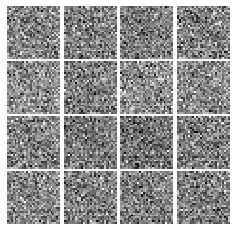


Iter: 250


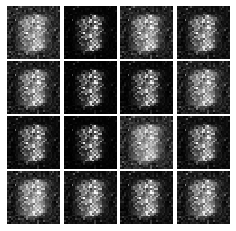


Iter: 500


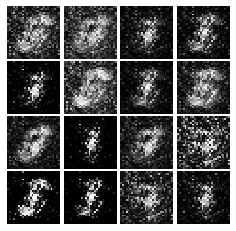


Iter: 750


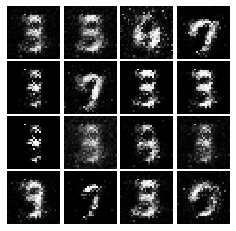


Iter: 1000


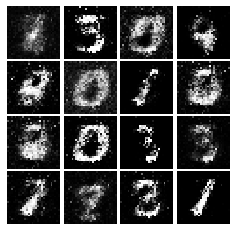


Iter: 1250


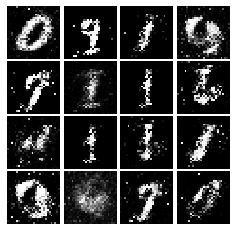


Iter: 1500


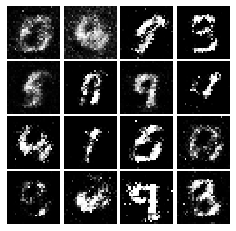


Iter: 1750


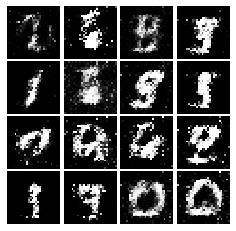


Iter: 2000


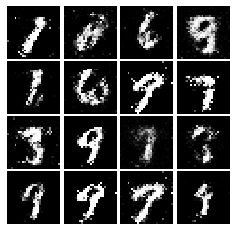


Iter: 2250


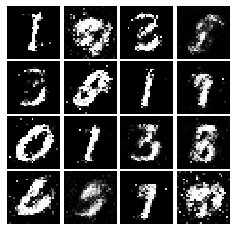


Iter: 2500


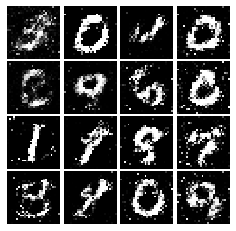


Iter: 2750


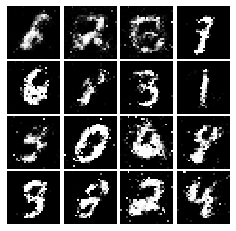


Iter: 3000


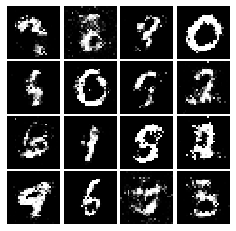


Iter: 3250


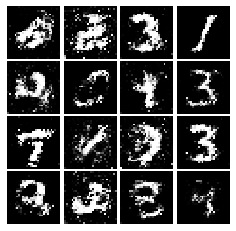


Iter: 3500


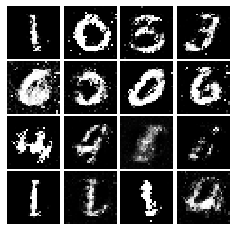


Iter: 3750


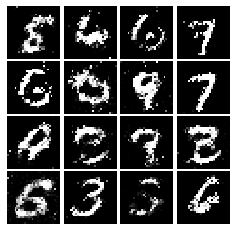

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

**Por favor adjunte en esta celda las imagenes generadas para la corrección del práctico.**

Iter: 0

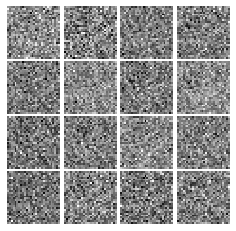

Iter 1000:

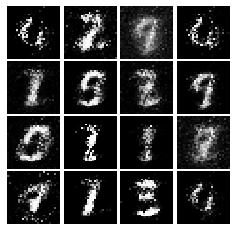

Iter 2000:

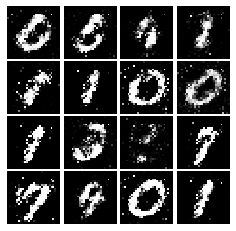

Iter 3000:

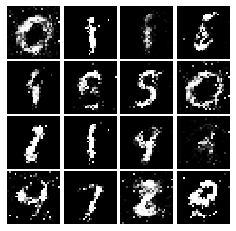

Iter 3750:

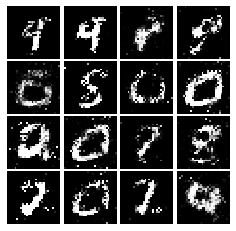

Bueno, eso no fue tan difícil, ¿verdad? Alrededor de las 100 iteraciones, debería ver fondos negros con formas borrosas y, a medida que se acerca a la iteración 1000, debería ver formas decentes. Aproximadamente la mitad de las imágenes serán nítidas y claramente reconocibles a medida que pasemos las 3000 iteraciones.

# GAN Mínimos cuadrados
Ahora veremos [Least Squares GAN] (https://arxiv.org/abs/1611.04076), una alternativa más nueva y estable a la función de pérdida de GAN original. Para esta parte, todo lo que tenemos que hacer es cambiar la función de pérdida y reentrenar el modelo. Implementaremos la ecuación (9) en el artículo, con la pérdida del generador:
$$ \ell_G = \frac {1} {2} \mathbb {E} _ {z \sim p (z)} \left [\left (D (G (z)) - 1 \right) ^ 2 \right ] $$
y la pérdida del discriminador:
$$ \ell_D = \frac {1} {2} \mathbb {E} _ {x \sim p_ \text {data}} \left [\left (D (x) -1 \right) ^ 2 \right] + \frac {1} {2} \mathbb {E} _ {z \sim p (z)} \left [\left (D (G (z)) \right) ^ 2 \right] $$


** SUGERENCIAS **: En lugar de calcular la esperanza, estaremos promediando elementos del minibatch, así que asegúrese de combinar la pérdida promediando en lugar de sumando. Cuando conecte con $ D(x) $ y $ D(G(z)) $ use la salida directa del discriminador (`scores_real` y` scores_fake`).

Implemente `ls_discriminator_loss`, `ls_generator_loss` en las siguientes celdas.

In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Calcula la pérdida de mínimos cuadrados para el discriminador.

    Entradas:
     - logits_real: PyTorch Tensor de forma (N,) que da puntuaciones para los datos reales.
     - logits_fake: PyTorch Tensor de forma (N,) que da puntuaciones para los datos falsos.

    Devuelve:
     - loss: PyTorch Tensor que contiene (escalar) la pérdida para el discriminador.
    """
    loss = None
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    loss = 0.5 * (torch.mean((scores_real - 1)**2) + torch.mean(scores_fake**2))

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    return loss

In [ ]:
def ls_generator_loss(scores_fake):
    """
    Calcula la pérdida de mínimos cuadrados para el generador.

    Entradas:
     - logits_fake: PyTorch Tensor de forma (N,) que da puntuaciones para los datos falsos.

    Devuelve:
     - loss: PyTorch Tensor que contiene (escalar) la pérdida para el discriminador.
    """
    loss = None
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    loss = 0.5 * torch.mean((scores_fake - 1)**2)

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    return loss

Antes de ejecutar una GAN con nuestra nueva función de pérdida, vamos a probarla:

In [ ]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Error máximo en d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Error máximo en g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Error máximo en d_loss: 1.53171e-08
Error máximo en g_loss: 2.7837e-09


Corré la siguiente celda para entrenar tu modelo.

In [ ]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, loader_train)

Iter: 0, D: 0.5044, G:0.4521
Iter: 250, D: 0.1231, G:0.268
Iter: 500, D: 0.1412, G:0.3852
Iter: 750, D: 0.1036, G:0.3824
Iter: 1000, D: 0.1006, G:0.4765
Iter: 1250, D: 0.1503, G:0.2954
Iter: 1500, D: 0.1216, G:0.3554
Iter: 1750, D: 0.2052, G:0.1926
Iter: 2000, D: 0.2112, G:0.2013
Iter: 2250, D: 0.2197, G:0.1794
Iter: 2500, D: 0.2123, G:0.171
Iter: 2750, D: 0.2231, G:0.1791
Iter: 3000, D: 0.2271, G:0.1576
Iter: 3250, D: 0.2384, G:0.2051
Iter: 3500, D: 0.2474, G:0.1644
Iter: 3750, D: 0.2254, G:0.1744


Corré la siguiente celda para mostrar las imágenes generados.

Iter: 0


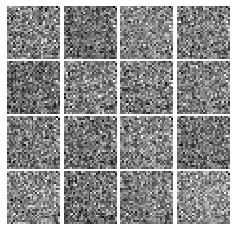


Iter: 250


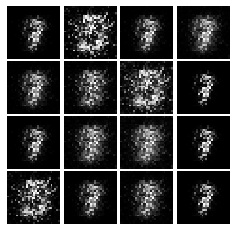


Iter: 500


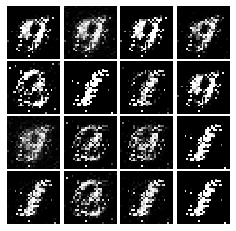


Iter: 750


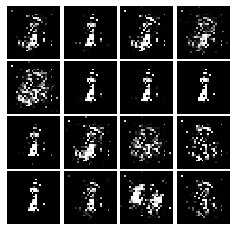


Iter: 1000


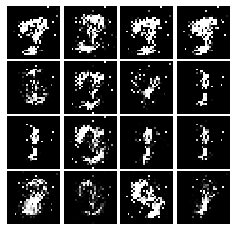


Iter: 1250


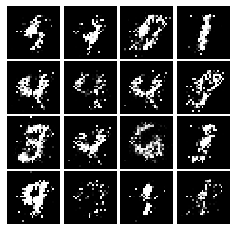


Iter: 1500


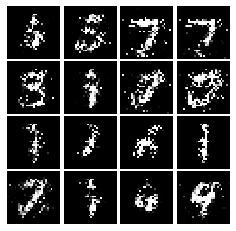


Iter: 1750


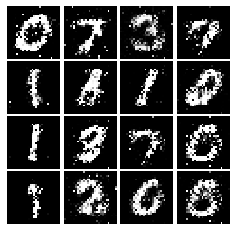


Iter: 2000


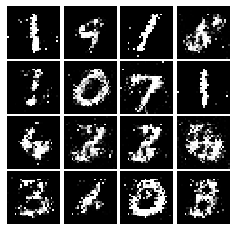


Iter: 2250


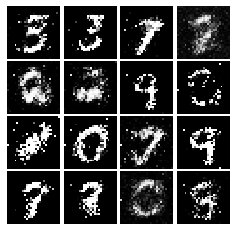


Iter: 2500


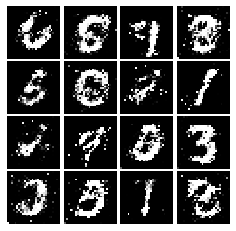


Iter: 2750


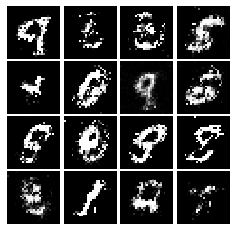


Iter: 3000


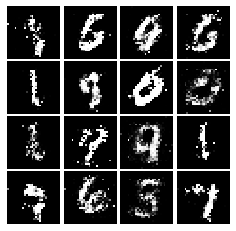


Iter: 3250


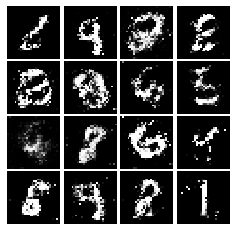


Iter: 3500


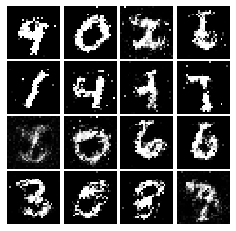


Iter: 3750


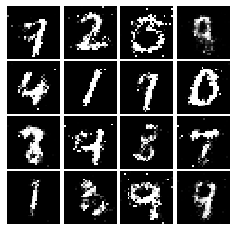

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

**Por favor adjunte en esta celda las imagenes generadas para la corrección del práctico.**

Iter 1000:

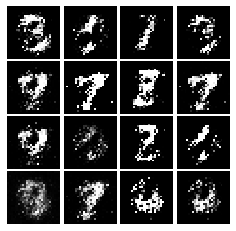

Iter 2000:

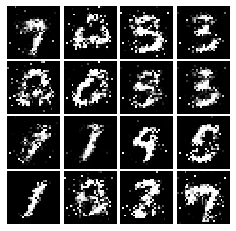

Iter 3000:

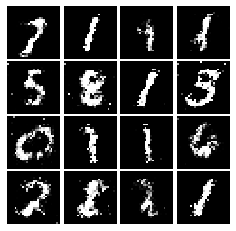

Iter 3750:

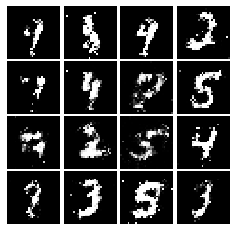

# GANs profundamente convolucionales
En la primera parte del notebook, implementamos una copia casi directa de la red GAN original de Ian Goodfellow. Sin embargo, esta arquitectura de red no permite un razonamiento espacial real. Es incapaz de razonar sobre cosas como "bordes afilados" en general porque carece de capas convolucionales. Así, en esta sección, implementaremos algunas de las ideas de [DCGAN](https://arxiv.org/abs/1511.06434), donde usamos redes convolucionales

#### Discriminador
Usaremos un discriminador inspirado en el tutorial de clasificación MNIST de TensorFlow, que puede obtener una precisión superior al 99% en el conjunto de datos MNIST con bastante rapidez.
* Cambiá la forma para que sea un tensor de imágenes (¡Usá Unflatten!)
* Conv2D: 32 filtros, 5x5, Stride 1
* Leaky ReLU((alfa = 0,01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 filtros, 5x5, Stride 1
* Leaky ReLU((alfa = 0,01)
* Max Pool 2x2, Stride 2
* Flatten
* Capa densa con 4 x 4 x 64 neuronas
* Leaky ReLU((alfa = 0,01)
* Capa densa con 1 neurona

Implementá `build_dc_classifier` en` la siguiente celda.

In [ ]:
def build_dc_classifier(batch_size):
    """
    Crea y devuelve un modelo PyTorch para el discriminador DCGAN que implementa
    la arquitectura anterior.
    """
    ##############################################################################
    # TODO: Implementá la arquitectura                                           #
    #                                                                            #
    # TIP: nn.Sequential puede ser útil.                                         #
    ##############################################################################
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    model = nn.Sequential(
        Unflatten(128, 1, 28, 28),
        nn.Conv2d(1, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(0.01),
        nn.Linear(4*4*64, 1),
        )

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    ##############################################################################
    #                               FIN DE SU CÓDIGO                            #
    ##############################################################################
    return model


In [ ]:
data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Verificá la cantidad de parámetros en tu clasificador por las dudas.

In [ ]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Número incorrecto de parámetros en el clasificador. Revisá tu arquitectura.')
    else:
        print('Número correcto de parámetros en el clasificador.')

test_dc_classifer()

Número correcto de parámetros en el clasificador.


#### Generador
Para el generador, copiaremos la arquitectura exactamente del [documento de InfoGAN](https://arxiv.org/pdf/1606.03657.pdf). Consulte el Apéndice C.1 MNIST. Consulte la documentación de [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). Siempre estamos "entrenando" en modo GAN.
* Capa densa con 1024 neuronas
* `ReLU`
* BatchNorm
* Capa densa con 7 x 7 x 128 neuronas
* ReLU
* BatchNorm
* Transformar la salida en un tensor de imagen de la forma (7, 7, 128)
* Conv2D ^ T (Transpuesta): 64 filtros de 4x4, stride 2,`padding = 1`
* `ReLU`
* BatchNorm
* Conv2D ^ T (Transpuesta): 1 filtro de 4x4, stride 2,`padding = 1`
* `TanH`
* Deberías tener una imagen de 28x28x1, volvé a darle forma de un vector de 784 elementos.

Implementar `build_dc_generator` en la siguiente celda.

In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Crea y devuelve un modelo PyTorch para el generador DCGAN que implementa
    la arquitectura anterior.
    """
    ##############################################################################
    # TODO: Implementá la arquitectura                                           #
    #                                                                            #
    # TIP: nn.Sequential puede ser útil.                                         #
    ##############################################################################
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    model = nn.Sequential(
        nn.Linear(noise_dim, 1024), nn.ReLU(), nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128), nn.ReLU(), nn.BatchNorm1d(7*7*128),
        Unflatten(-1, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, 4, 2, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 4, 2, padding=1), nn.Tanh(),
        Flatten()
        )

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    ##############################################################################
    #                               FIN DE SU CÓDIGO                            #
    ##############################################################################
    return model

In [ ]:
test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Verificá la cantidad de parámetros en tu generador por las dudas.

In [ ]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Número incorrecto de parámetros en el generador. Revisá tu arquitectura.')
    else:
        print('Número correcto de parámetros en el generador.')

test_dc_generator()

Número correcto de parámetros en el generador.


Corré la siguiente celda para entrenar tu modelo.

In [ ]:
D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train, num_epochs=5)

Iter: 0, D: 1.511, G:1.3
Iter: 250, D: 1.225, G:0.8302
Iter: 500, D: 1.222, G:1.443
Iter: 750, D: 1.118, G:1.07
Iter: 1000, D: 1.276, G:0.8009
Iter: 1250, D: 1.218, G:1.025
Iter: 1500, D: 1.088, G:0.8943
Iter: 1750, D: 1.051, G:0.9767


Corré la siguiente celda para mostrar las imágenes generados.

Iter: 0


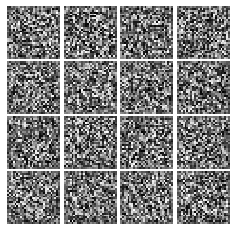


Iter: 250


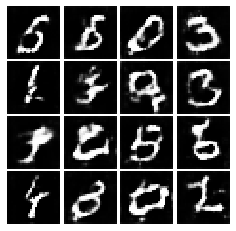


Iter: 500


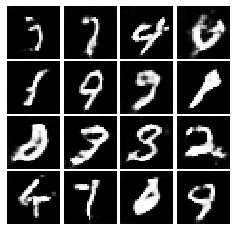


Iter: 750


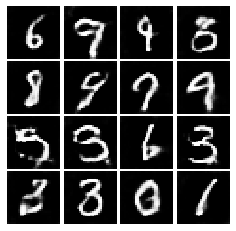


Iter: 1000


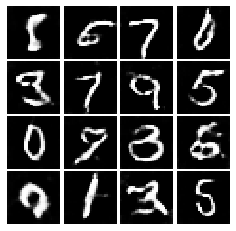


Iter: 1250


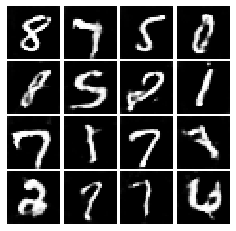


Iter: 1500


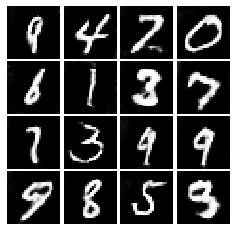


Iter: 1750


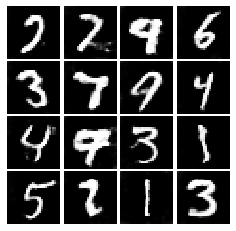

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

**Por favor adjunte en esta celda las imagenes generadas para la corrección del práctico.**

Iter 1000:

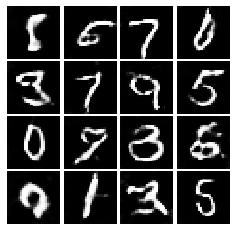

Iter 1750:

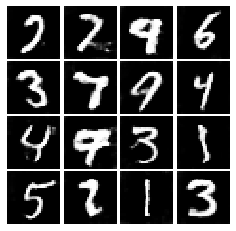